### Tarea 02 - Aprendizaje maquina

### Giovanni Gamaliel López Padilla

### Librerias

In [ ]:
!pip install git+https://github.com/tensorflow/examples.git
from keras.preprocessing.image import ImageDataGenerator
from tensorflow_examples.models.pix2pix import pix2pix
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Activation
from tensorflow.keras.optimizers import Nadam
from keras.applications import mobilenet_v2
from os import listdir,makedirs
from argparse import Namespace
from tensorflow import keras
from pandas import DataFrame
from os.path import join
import tensorflow as tf
from PIL import Image
import numpy as np

  Cloning https://github.com/tensorflow/examples.git to /tmp/pip-req-build-c_zt50fc
  Running command git clone -q https://github.com/tensorflow/examples.git /tmp/pip-req-build-c_zt50fc


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Definicion de los parametros y argumentos

In [ ]:
def get_params() -> dict:
    """
    parametros de los datos a tratar
    """
    params = {
        # Direccion de los datos
        "path data": "/content/drive/MyDrive/Aprendizaje_maquina/Tareas/Tarea_04/Data",
        # Direccion original de los datos 
        "path data normal": "/content/drive/MyDrive/Aprendizaje_maquina/Tareas/Tarea_04/Data/images",
        # Direccion original de las mascaras
        "path data mask": "/content/drive/MyDrive/Aprendizaje_maquina/Tareas/Tarea_04/Data/masks",
        # Direccion de los resultados
        "path results": "/content/drive/MyDrive/Aprendizaje_maquina/Tareas/Tarea_04/Results",
    }
    return params

def get_args(params:dict)->Namespace:
    """
    Definicion de los argumentos a utilizar en los entrenamientos
    """
    args=Namespace()
    args.train_len = len(params["train images"])
    args.val_len = len(params["train images"])
    args.batch_size = 32
    args.steps_per_epoch = args.train_len // args.batch_size
    args.epochs = 15
    return args


def ls(path:str)->list:
    """
    Estandarización del listdir
    """
    files=sorted(listdir(path))
    return files

def mkdir(path:str)->None:
    """
    Estandarizacion del makedirs
    """
    makedirs(path,
             exist_ok=True)

def organization_files(params:dict,is_organized:bool=True)->dict:
    """
    Organización de los datos obtenidos en la pagina
    https://www.kaggle.com/datasets/mateuszbuda/lgg-mri-segmentation

    params: diccionario con las direcciones de los datos
    is_organized: booleano que le indica si los datos ya se encuentran organizados
    """
    # Definicion de los nombres de todos los archivos
    params=get_filenames(params)
    # Definicion de las direcciones de los datos organizados
    params["path train images"]=join(params["path data"],
                                     "train_images/train")
    params["path train mask"]=join(params["path data"],
                                     "train_masks/train")
    params["path validation images"]=join(params["path data"],
                                     "val_images/val")
    params["path validation mask"]=join(params["path data"],
                                     "val_masks/val")
    # Definicion de las direcciones de los datos generalizados
    params["path train images g"]=join(params["path data"],
                                     "train_images")
    params["path train mask g"]=join(params["path data"],
                                     "train_masks")
    params["path validation images g"]=join(params["path data"],
                                     "val_images")
    params["path validation mask g"]=join(params["path data"],
                                     "val_masks")
    # Lista de carpetas a crear
    folders=["path train images",
             "path train mask",
             "path validation images",
             "path validation mask",]
    for folder in folders:
        mkdir(params[folder])
    # Definicion de las carpetas originales
    params["train images"]=ls(params["path train images"])
    params["train mask"]=ls(params["path train mask"])
    params["validation images"]=ls(params["path validation images"])
    params["validation mask"]=ls(params["path validation mask"])
    if is_organized:
        # Ominit organizacion porque ya se encuentra hecha
        return params
    # Split de los datos
    train_images, test_images, train_masks, test_masks = train_test_split(params["files data"],
                                                                          params["files target"],
                                                                          test_size=0.2,
                                                                          random_state = 54)
    #save images and masks in folders
    for file in train_images:
        filename=join(params["path data normal"],
                      file)
        img = Image.open(filename)
        filename =join(params["path train images"],
                       file)
        img.save(filename)
        filename = join(params["path data mask"],
                        file)
        mask = Image.open(filename)
        filename = join(params["path train mask"],
                        file)
        mask.save(filename)
    # save images and masks in folders
    for file in test_images:
        filename=join(params["path data normal"],
                      file)
        img = Image.open(filename)
        filename =join(params["path validation images"],
                       file)
        img.save(filename)
        filename = join(params["path data mask"],
                        file)
        mask = Image.open(filename)
        filename = join(params["path validation mask"],
                        file)
        mask.save(filename)
    return params

def get_filenames(params:dict)->dict:
    """
    Obtiene los nombres de los datos
    """
    params["files data"]=ls(params["path data normal"])
    params["files target"]=ls(params["path data mask"])
    return params

### Definicion del generador de imagenes

In [ ]:
class generator_model:
    def __init__(self, params,args):
        """
        Contiene los metodos para generar imagenes a partir de las encontradas en las rutas de entrenamiento y test

        Inputs:
        -----------------------
        params -> directorio con los diferentes parámetros a usar
            params["paths"] -> diccionario con las diferentes rutas de los archivos
                params["paths"]["train"] -> directorio con las diferentes rutas de datos de entrenamiento
                    params["paths"]["train"]["base"] -> ruta de los documentos de entrenamiento
                params["paths"]["test"] -> directorio con las diferentes rutas de los datos de test
                    params["paths"]["test"]["base"] -> ruta con los documentos de test
        """

        self.params = params
        self.args=args
        self._set_generators()
        self._get_data()
        self._get_validation()

    def _set_generators(self)->dict:
        """
        Definicon de los generadores para los datos y las mascaras
        """
        self.image_data_args = dict(rotation_range=90,
                                    width_shift_range=0.3,
                                    height_shift_range=0.3,
                                    shear_range=0.5,
                                    zoom_range=0.3,
                                    horizontal_flip=True,
                                    vertical_flip=True,
                                    fill_mode='reflect',
        )
        self.mask_data_args = dict(rotation_range=90,
                                    width_shift_range=0.3,
                                    height_shift_range=0.3,
                                    shear_range=0.5,
                                    zoom_range=0.3,
                                    horizontal_flip=True,
                                    vertical_flip=True,
                                    fill_mode='reflect',
                                    preprocessing_function = lambda x: np.where(x>0, 1, 0).astype(x.dtype))

    def _get_data(self) -> None:
        """
        Creacion de los generadores de datos para los datos de entrenamiento y validacion
        """
        image_data_generator = ImageDataGenerator(**self.image_data_args,
                                                  rescale=1.0/255.0)
        self.train_image_generator = image_data_generator.flow_from_directory(self.params["path train images g"],
                                                                batch_size=self.args.batch_size,
                                                                class_mode=None,
                                                                seed=54)
        masks_data_generator = ImageDataGenerator(**self.mask_data_args)
        self.train_mask_generator = masks_data_generator.flow_from_directory(self.params["path train mask g"],
                                                                        class_mode=None,
                                                                        seed=54,
                                                                        batch_size=self.args.batch_size)
        self.train=self.image_mask_generator(self.train_image_generator,
                                                     self.train_mask_generator)


    def _get_validation(self) -> None:
        """
        Creacion de los generadores de datos para los datos de test
        """
        image_data_generator = ImageDataGenerator(rescale=1.0/255.0)
        self.test_image_generator=image_data_generator.flow_from_directory(self.params["path validation images g"],
                                                                    batch_size=10,
                                                                    seed=54,
                                                                    class_mode=None)
        self.test_masks_generator = image_data_generator.flow_from_directory(self.params["path validation mask g"],
                                                                        batch_size=10,
                                                                        seed=54,
                                                                        class_mode=None)
        self.validation=self.image_mask_generator(self.test_image_generator,
                                                          self.test_masks_generator)
        
    def image_mask_generator(self,image_generator, mask_generator)->tuple:
        train_generator = zip(image_generator, mask_generator)
        for (img, mask) in train_generator:
            mask=mask[:,:,:,0]
            mask=np.expand_dims(mask, 
                                axis=3)
            # append 
            yield (img, mask) 

In [ ]:
class unet_model:
    def __init__(self,unfreeze:str)->None:
        output_classes = 1
        self._create_mobilenet(unfreeze)
        self.model=self._basic_unet_model(output_classes)
    
    def _create_mobilenet(self,unfreeze:str)->None:
        base_model=mobilenet_v2.MobileNetV2(input_shape=[256,
                                                         256,
                                                         3],
                                            include_top=False)
        layer_names = [
            # 64x64
            'block_1_expand_relu',   
            # 32x32
            'block_3_expand_relu',   
            # 16x16
            'block_6_expand_relu',   
            # 8x8
            'block_13_expand_relu',  
            # 4x4
            'block_16_project',      
        ]
        base_model_outputs = [base_model.get_layer(name).output
                              for name in layer_names]
        # Create the feature extraction model
        self.down_stack = tf.keras.Model(inputs=base_model.input,
                                         outputs=base_model_outputs)
        self.down_stack.trainable = False
        self._set_unfreeze(unfreeze)
        self.up_stack = [
            # 4x4 -> 8x8
            pix2pix.upsample(512, 3),
            # 8x8 -> 16x16
            pix2pix.upsample(256, 3),
            # 16x16 -> 32x32
            pix2pix.upsample(128, 3),
            # 32x32 -> 64x64
            pix2pix.upsample(64, 3),
        ]

    def _set_unfreeze(self,unfreeze:str)->None:
        """
        Modos para descongelar parametros de la red de Mobile
        """
        if unfreeze=="all":
            self.down_stack.trainable=True
        if unfreeze=="last conv":
            for layer in self.down_stack.layers:
                if layer.name=="block_16_project":
                    layer.trainable=True
        if unfreeze=="none":
            pass

    def _basic_unet_model(self,output_channels:int)->tf.keras.Model:
        inputs = tf.keras.layers.Input(shape=[256, 256, 3])
        # Downsampling through the model
        skips = self.down_stack(inputs)
        x = skips[-1]
        skips = reversed(skips[:-1])
        # Upsampling and establishing the skip connections
        for up, skip in zip(self.up_stack, skips):
            x = up(x)
            concat = tf.keras.layers.Concatenate()
            x = concat([x, skip])
        # This is the last layer of the model
        #64x64 -> 128x128
        last = tf.keras.layers.Conv2DTranspose(filters=output_channels,
                                               kernel_size=3,
                                               strides=2,
                                               padding='same') 
        x = last(x)
        x = Activation("sigmoid")(x)
        return tf.keras.Model(inputs=inputs, outputs=x)
    
    def compile(self)->None:
        """
        Compilacion del modelo
        """
        self.model.compile(optimizer=Nadam(learning_rate = 1e-4), 
                           loss="binary_crossentropy",
                           metrics=['accuracy'])   

    def run(self,params:dict,args:Namespace)->DataFrame:
        """
        Ejecuccion del modelo realizando el guardado del historial y los pesos del modelo
        """
        filename=join(params["path results"],
                      "checkpoint.pt")
        checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=filename,
                                                        save_weights_only=True,
                                                        monitor='val_accuracy',
                                                        mode='max',
                                                        save_best_only=True)
        self.history = self.model.fit(data_generator.train,
                    validation_data=data_generator.validation,
                    steps_per_epoch=args.steps_per_epoch, 
                    validation_steps=args.steps_per_epoch,
                    epochs=args.epochs,
                    callbacks=[checkpoint])
        self.save_history(params)
        self.save_model(params)
        
    def save_history(self,params:dict)->None:
        """
        Guardado del historial del modelo
        """
        history=DataFrame(self.history.history)
        history.index.name="Epoch"
        mkdir(params["path results"])
        filename=join(params["path results"],
                      params["history name"])
        history.to_csv(filename)
    
    def save_model(self,params:dict)->None:
        """
        Guardado del modelo
        """
        filename=join(params["path results"],
                      params["model name"])
        self.model.save(filename)

    def summary(self)->None:
        """
        Facil acceso al summary del modelo
        """
        self.model.summary()
    
    def load(self,filename:str)->None:
        self.model.load_weights(filename)
    
    def predict(self,image:np.array)->np.array:
        test_image=transform_image(image)
        result=self.model.predict(test_image)
        predict=(result[0,:,:,:] > 0.5).astype(np.uint8)
        return predict
    
def transform_image(image:np.array)->np.array:
    test_image=np.expand_dims(image, 0)
    return test_image

### Parametros de direcciones y argumentos del modelo

In [ ]:
params=get_params()
params=organization_files(params)
args=get_args(params)
data_generator=generator_model(params,args)

Found 3055 images belonging to 1 classes.
Found 3055 images belonging to 1 classes.
Found 764 images belonging to 1 classes.
Found 764 images belonging to 1 classes.


### Capas no entrenables

In [ ]:
model=unet_model("none")
model.compile()
params["model name"]="model_01.h5"
params["history name"]="history_01.csv"
model.run(params,args)

Epoch 1/15
95/95 [==============================] - 2322s 25s/step - loss: 0.5097 - accuracy: 0.7297 - val_loss: 0.2597 - val_accuracy: 0.9890
Epoch 2/15
95/95 [==============================] - 97s 1s/step - loss: 0.1804 - accuracy: 0.9875 - val_loss: 0.1234 - val_accuracy: 0.9900
Epoch 3/15
95/95 [==============================] - 96s 1s/step - loss: 0.1035 - accuracy: 0.9880 - val_loss: 0.0807 - val_accuracy: 0.9898
Epoch 4/15
95/95 [==============================] - 97s 1s/step - loss: 0.0695 - accuracy: 0.9902 - val_loss: 0.0594 - val_accuracy: 0.9902
Epoch 5/15
95/95 [==============================] - 96s 1s/step - loss: 0.0537 - accuracy: 0.9911 - val_loss: 0.0451 - val_accuracy: 0.9913
Epoch 6/15
95/95 [==============================] - 96s 1s/step - loss: 0.0438 - accuracy: 0.9919 - val_loss: 0.0349 - val_accuracy: 0.9936
Epoch 7/15
95/95 [==============================] - 97s 1s/step - loss: 0.0383 - accuracy: 0.9921 - val_loss: 0.0308 - val_accuracy: 0.9939
Epoch 8/15
95/95 

### Fine tunning

In [ ]:
model = unet_model("last conv")
model.compile()
params["model name"]="model_02.h5"
params["history name"]="history_02.csv"
model.run(params,args)

Epoch 1/15
95/95 [==============================] - 102s 1s/step - loss: 0.5431 - accuracy: 0.7013 - val_loss: 0.2631 - val_accuracy: 0.9875
Epoch 2/15
95/95 [==============================] - 97s 1s/step - loss: 0.1909 - accuracy: 0.9868 - val_loss: 0.1285 - val_accuracy: 0.9898
Epoch 3/15
95/95 [==============================] - 96s 1s/step - loss: 0.1087 - accuracy: 0.9878 - val_loss: 0.0817 - val_accuracy: 0.9902
Epoch 4/15
95/95 [==============================] - 96s 1s/step - loss: 0.0725 - accuracy: 0.9903 - val_loss: 0.0605 - val_accuracy: 0.9901
Epoch 5/15
95/95 [==============================] - 96s 1s/step - loss: 0.0553 - accuracy: 0.9913 - val_loss: 0.0480 - val_accuracy: 0.9908
Epoch 6/15
95/95 [==============================] - 98s 1s/step - loss: 0.0454 - accuracy: 0.9919 - val_loss: 0.0378 - val_accuracy: 0.9925
Epoch 7/15
95/95 [==============================] - 97s 1s/step - loss: 0.0389 - accuracy: 0.9925 - val_loss: 0.0300 - val_accuracy: 0.9945
Epoch 8/15
95/95 [=

### Full tunning

In [ ]:
model = unet_model("all")
model.compile()
params["model name"]="model_03.h5"
params["history name"]="history_03.csv"
model.run(params,args)

Epoch 1/15
95/95 [==============================] - 118s 1s/step - loss: 0.3561 - accuracy: 0.7979 - val_loss: 0.2523 - val_accuracy: 0.8144
Epoch 2/15
95/95 [==============================] - 104s 1s/step - loss: 0.1301 - accuracy: 0.9901 - val_loss: 0.1352 - val_accuracy: 0.9886
Epoch 3/15
95/95 [==============================] - 105s 1s/step - loss: 0.0677 - accuracy: 0.9938 - val_loss: 0.0970 - val_accuracy: 0.9898
Epoch 4/15
95/95 [==============================] - 104s 1s/step - loss: 0.0436 - accuracy: 0.9946 - val_loss: 0.0777 - val_accuracy: 0.9905
Epoch 5/15
95/95 [==============================] - 103s 1s/step - loss: 0.0322 - accuracy: 0.9951 - val_loss: 0.0643 - val_accuracy: 0.9913
Epoch 6/15
95/95 [==============================] - 103s 1s/step - loss: 0.0254 - accuracy: 0.9954 - val_loss: 0.0617 - val_accuracy: 0.9901
Epoch 7/15
95/95 [==============================] - 102s 1s/step - loss: 0.0212 - accuracy: 0.9959 - val_loss: 0.0539 - val_accuracy: 0.9910
Epoch 8/15
95

### Resultados

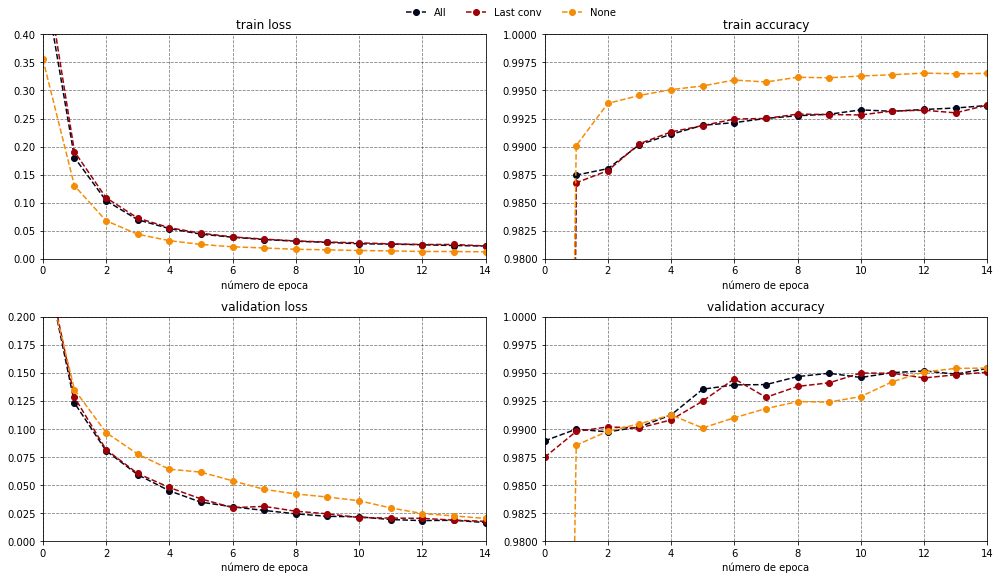

In [ ]:
from numpy import linspace, array
import matplotlib.pyplot as plt
from pandas import read_csv
from os.path import join

datasets_parameters = {
    "files":["history_01.csv",
             "history_02.csv",
             "history_03.csv"],
    "loss": {
        "y lim": [0, 0.4],
        "title": "train loss"
    },
    "accuracy": {
        "y lim": [0.98, 1],
        "title": "train accuracy"},
    "val_loss": {
        "y lim": [0, 0.2],
        "title": "validation loss"
    },
    "val_accuracy": {
        "y lim": [0.98, 1],
        "title": "validation accuracy"
    },
}
colors = {"history_01.csv": {"color":"#03071e",
                             "title": "All"},
          "history_02.csv": {"color":"#9d0208",
                             "title": "Last conv"},
          "history_03.csv": {"color":"#f48c06",
                             "title": "None"},
          }
history={}
for filename in datasets_parameters["files"]:
    file = join(params["path results"],
                    filename)
    data = read_csv(file,
                    index_col=0)
    history[filename] = data.copy()

fig, axs = plt.subplots(2, 2,
                        figsize=(14, 8))
axs=axs.flatten()
for train_type in history:
    data = history[train_type]
    color = colors[train_type]["color"]
    title = colors[train_type]["title"]
    for ax, parameter in zip(axs, data.columns):
        dataset = datasets_parameters[parameter]
        parameter_data = data[parameter]
        epochs = list(data.index)
        ax.plot(epochs,
                parameter_data,
                label=title,
                color=color,
                ls="--",
                marker="o")
        ax.set_title(datasets_parameters[parameter]["title"])
        ax.set_xlabel("número de epoca")
        ax.set_xlim(0,14)
        ax.set_ylim(dataset["y lim"][0],
                    dataset["y lim"][1])
        ax.grid(ls="--",
                color="#000000",
                alpha=0.5)
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles,
           labels,
           bbox_to_anchor=(0.62,
                           1.01),
           ncol=3,
           frameon=False
           )
plt.tight_layout()
plt.show()

La función de perdida para los datos de entrenamiento y validación decae conforme aumenta el número de epoca. Teniendo que la red con los pesos congelados de MobileNet obtiene valores menores en el conjunto de entrenamiento, en cambio, la red con todos los nodos descongelados y descongelando la última capa convolucional obtiene menores con el conjunto de validación.

Una situación semejante sucede con los valores de accuracy. En el conjunto de entramiento, la red con los pesos de MobleNet obtiene mejores resultados, sin embargo, el accuracy obtenido con los datos de validación es semejante en los tres tipos de modelos. Los modelos con capas descongeladas obtiene mejores valores de accuracy con menor número de epocas.

Realizando comparaciones con Israr Ahmed (https://www.kaggle.com/code/israrahmed919/brain-mri-segmentation-usingtf-unet), el modelo obtenido en esta tarea refleja mejores valores a los reportados en su gráfica. La diferencia entre los resultados no es significante.

### Predicciones

In [ ]:
images,masks=next(data_generator.validation)

#### Lectura de los modelos

In [ ]:
model_none=unet_model("none")
model_none.compile()
filename=join(params["path results"],
              "model_01.h5")
model_none.load(filename)

filename=join(params["path results"],
              "model_02.h5")
model_last=tf.keras.models.load_model(filename)

model_all=unet_model("all")
model_all.compile()
filename=join(params["path results"],
              "model_03.h5")
model_all.load(filename)

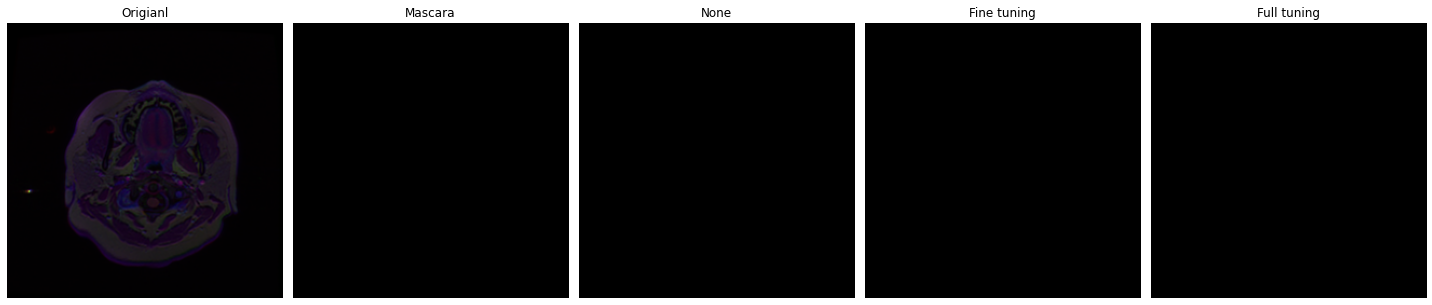

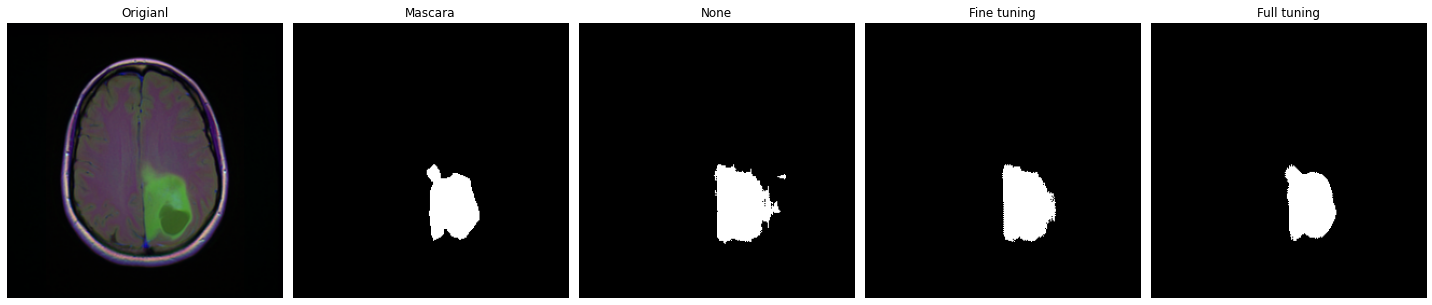

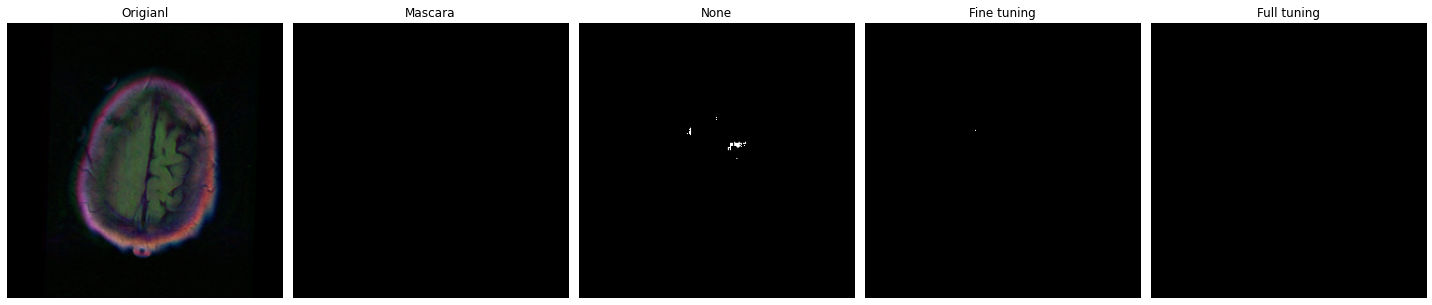

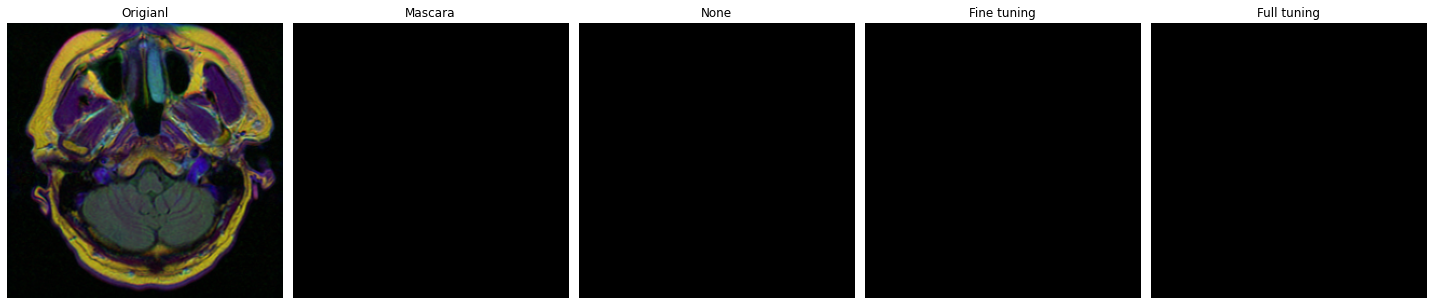

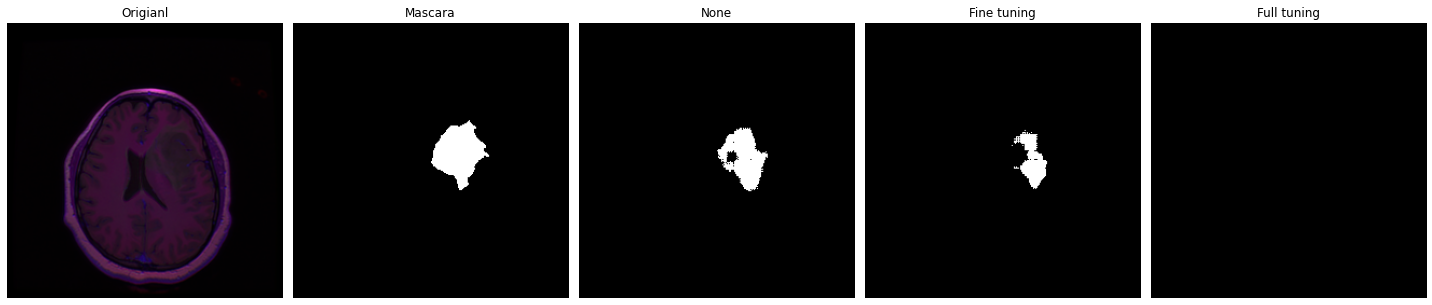

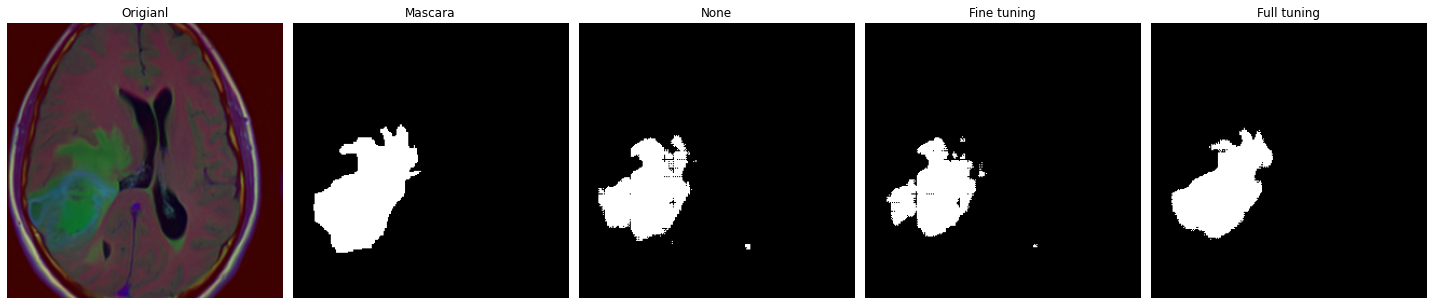

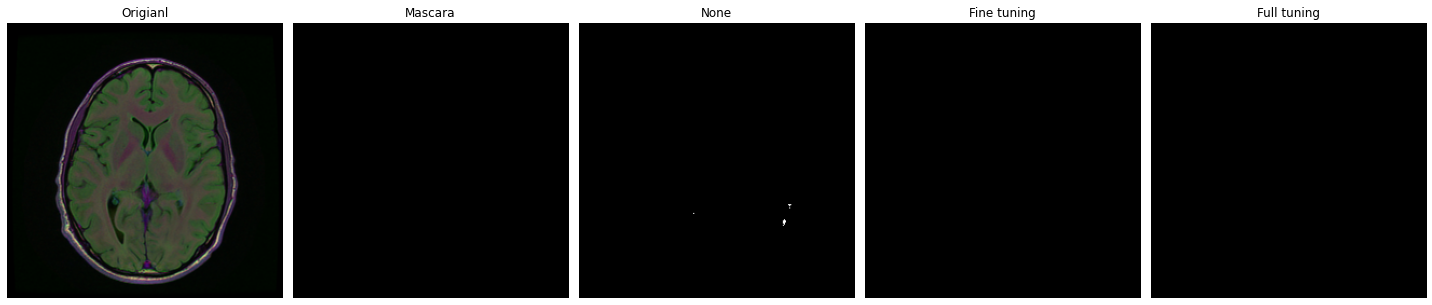

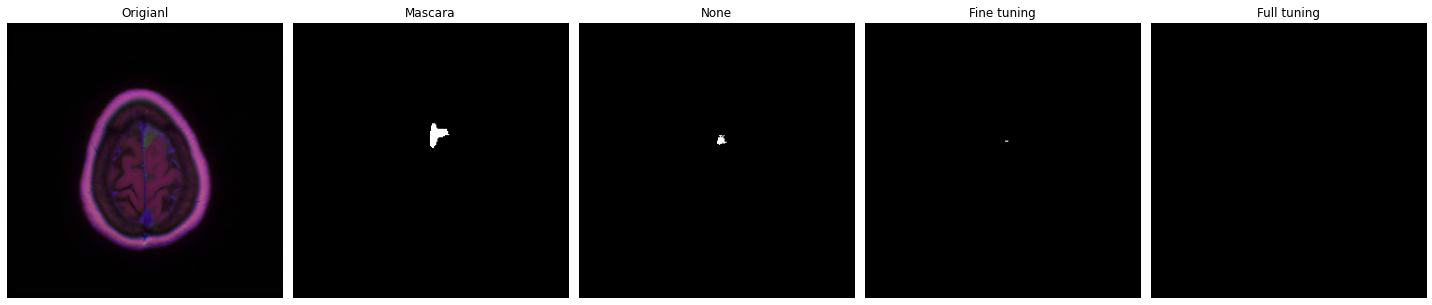

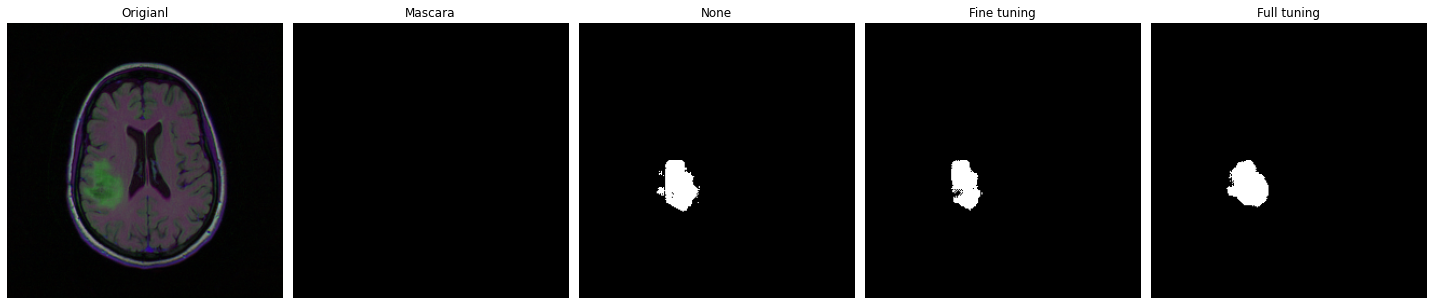

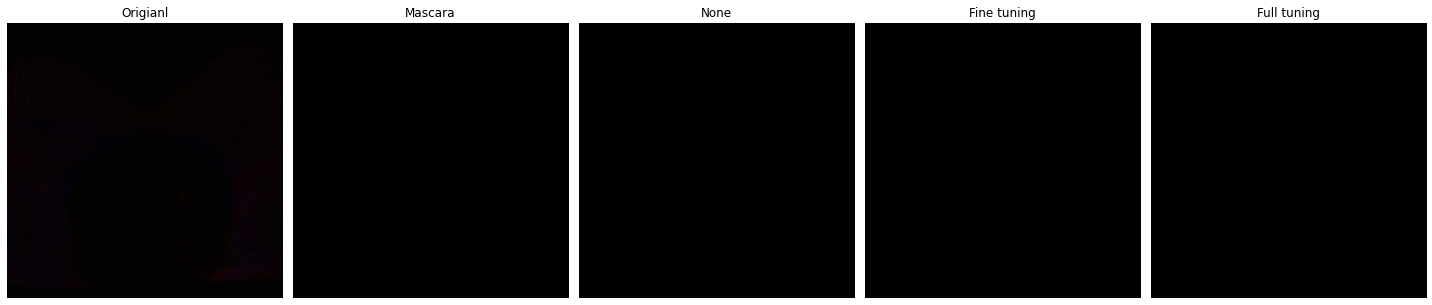

In [ ]:
import matplotlib.pyplot as plt
def plot(ax:plt.axes,image:np.array,title:str):
    ax.set_title(title)
    ax.imshow(image,
              cmap="gray")
    ax.axis("off")

for image,mask in zip(images,masks):
    # Prediccion none
    predict_none = model_none.predict(image)
    # Prediction last conv
    test_image=transform_image(image)
    predict_last = model_last.predict(test_image)
    predict_last=(predict_last[0,:,:,:]>0.5)
    # Prediccion all
    predict_all = model_all.predict(image)
    fig,(ax1,ax2,ax3,ax4,ax5)=plt.subplots(1,5,
                                        figsize=(20,8))
    plot(ax1,image,"Origianl")
    plot(ax2,mask[:,:,0],"Mascara")
    plot(ax3,predict_none[:,:,0],"None")
    plot(ax4,predict_last[:,:,0],"Fine tuning")
    plot(ax5,predict_all[:,:,0],"Full tuning")
    plt.tight_layout()
    plt.show()

A partir de las figuras anteriores se puede verificar que el trabajo que realiza el modelo es eficiente llegando a identificar cuando se tiene un tumor o no por medio de la resonancia magnética. La red con las capas congeladas obtiene mejores resultados cuando el tumor es pequeño y la red con todas las capas congeladas cuando el tumor es grande